---
# Tutorial Topic: Portfolio Optimisation
---


In this tutorial, our goal is to build from the lecture notes by adding in Gold as an asset to our universe of assets in which we can build a portfolio.

After completing this tutorial, students should be more familiar with:
- Pandas for basic data analysis
- Using functions and classes
- Portfolio optimisation techniques


##### **What we want to answer: Given data of Gold and various ETF's representing US industries, what is the best risk-adjusted return (sharpe ratio) we can achieve in a portfolio?**

# Revision of Portfolio Optimisation Steps

Assume you already have:

- **Expected returns vector**: $\mu = [\mu_1, \mu_2, \dots, \mu_n]^T$
- **Covariance matrix**: $\Sigma$
- **Standard deviations**: $\sigma_i = \sqrt{\Sigma_{ii}}$
- **Risk-free rate**: $r_f$

We want to find the **optimal portfolio weights** $w = [w_1, w_2, \dots, w_n]^T$.

---

## 1. Define Portfolio Return, Volatility, and Sharpe Ratio

- **Expected Portfolio Return**:

$$
r_p = w^T \mu
$$

- **Portfolio Volatility (Standard Deviation)**:

$$
\sigma_p = \sqrt{w^T \Sigma w}
$$

- **Portfolio Sharpe Ratio**:

$$
S_p = \frac{r_p - r_f}{\sigma_p} = \frac{w^T \mu - r_f}{\sqrt{w^T \Sigma w}}
$$

---

## 2. Optimization Objectives

- **To Maximize Sharpe Ratio**:

Maximize:

$$
S_p = \frac{w^T \mu - r_f}{\sqrt{w^T \Sigma w}}
$$

- **To Minimize Volatility**:

Minimize:

$$
\sigma_p = \sqrt{w^T \Sigma w}
$$

---

## 3. Constraints

- **Budget Constraint**:

$$
\sum_{i=1}^{n} w_i = 1
$$

- **No Short Selling (optional - not always true)**:

$$
w_i \geq 0 \quad \text{for all } i
$$

---

## 4. Solving the Optimization Problem

- **Use a numerical optimizer** (e.g., `scipy.optimize.minimize`) to solve for $w$.
- **Inputs**:
  - Objective function (`-Sharpe ratio` for max Sharpe, `portfolio volatility` for min volatility)
  - Constraints (weights sum to 1)
  - Bounds (weights between 0 and 1, if no short selling)
- **Output**:
  - Optimal portfolio weights $w^*$
  - Corresponding expected return $r_p$, volatility $\sigma_p$, and Sharpe ratio $S_p$.

---

# Summary

- **Inputs**: $\mu$, $\Sigma$, $r_f$
- **Decisions**: $w$
- **Goals**:
  - Maximize Sharpe ratio or
  - Minimize volatility
- **Constraints**:
  - $\sum w_i = 1$
  - Optional: $w_i \geq 0$

Once $w^*$ is found, you can fully characterize the optimal portfolio.

---


# Doing this in code:

In [ ]:
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the tickers (ETFs)
tickers = [
    'GLD',  # Gold
    'XLE',  # Energy
    'XLB',  # Materials
    'XLI',  # Industrials
    'XLY',  # Consumer Discretionary
    'XLP',  # Consumer Staples
    'XLV',  # Health Care
    'XLF',  # Financials
    'XLK',  # Information Technology
    'XLC',  # Communication Services
    'XLU'   # Utilities
]

# Download 5 years of daily data
data = yf.download(tickers, start="2020-04-27", end="2025-04-27")['Close']


[*********************100%***********************]  11 of 11 completed


In [19]:
data.head()

Ticker,GLD,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,,,
2020-04-27,161.559998,46.335712,46.863586,28.778662,20.474920,58.345024,85.723923,51.611599,50.392494,93.899879,109.790466
2020-04-28,160.839996,47.195629,46.013432,29.437712,20.693516,59.436104,84.582695,51.900852,50.580624,92.004868,110.222542
2020-04-29,161.729996,48.399502,48.239117,31.618286,21.294641,60.573429,88.054253,51.681713,50.118855,92.614990,112.651642
2020-04-30,158.800003,46.960278,48.028957,30.918552,20.757269,59.371380,87.661072,51.068138,48.964432,92.189758,111.950745
2020-05-01,159.779999,45.973640,47.360317,29.169210,20.092384,57.577572,85.253998,50.507126,47.784363,90.433411,107.764595


#### Next Steps:

We need 3 pieces of information from the dataset to successfully generate an efficient portfolio:
- Average returns 
- Covariance Matrix (covariance of returns)
- Volatilities (defined: standard deviation of returns)

In [ ]:
## Use this code cell to calculate the average yearly returns, covariance matrix and volatility of each asset 

## Tips: Pandas has an inbuilt function for returns
##       Remember to drop the NaN created in the first period
##       Yearly returns are generating by extrapolating from the average daily return (by 252 trading days)

## Calculate daily returns
returns = data.pct_change().dropna()
mean_returns = returns.mean() * 252  # Annualised expected returns

## Calculate the Covariance Matrix 
## by calcualting daily covariance (hint, there is a pandas function for this) and extrapolating for the year (252 trading days)
cov_matrix = returns.cov() * 252     # Annualised covariance matrix

## Calculate Volatility
## Tips: Volatility is the standard deviation of returns (there is a pandas function for this)
##       Variance of returns scales linearly with trading days
##       Since volatility is the sqrt(variance of returns), it scaled with sqrt(252)

volatilities = returns.std() * np.sqrt(252) # Annualised volatility

#### Create the Optimisation and Plotter [as done in Lecture]

In [31]:
class MultiAssetOptimisation:
    def __init__(self, returns, cov_matrix, asset_names, volatilities, num_portfolios=1_000_000, risk_free_rate=0.045, weighting_style='dirichlet'):
        self.returns = np.array(returns)
        self.asset_names = asset_names
        self.num_portfolios = num_portfolios
        self.risk_free_rate = risk_free_rate
        self.weighting_style = weighting_style
        self.cov_matrix = np.array(cov_matrix)
        self.volatilities = np.array(volatilities)
        self.ALPHA = 0.3

    # Don't make students generate this themselves
    def _get_weights(self):
        n = len(self.returns)

        if self.weighting_style == 'normalised':
            weights = np.random.random((self.num_portfolios, n))
            weights /= weights.sum(axis=1)[:, None]

        elif self.weighting_style == 'dirichlet':
            weights = np.random.dirichlet(self.ALPHA * np.ones(n), size=self.num_portfolios)

        elif self.weighting_style == 'constrain-assets':
            weights = []
            for _ in range(self.num_portfolios):
                w = np.zeros(n)
                i, j = np.random.choice(n, size=2, replace=False)
                vals = np.random.random(2)
                vals /= vals.sum()
                w[i], w[j] = vals
                weights.append(w)
            weights = np.array(weights)

        else:
            raise ValueError("Invalid weighting_style. Choose 'normalised', 'dirichlet', or 'constrain-assets'.")

        return weights

    def plot_efficient_frontier(self):
        weights = self._get_weights()

        # Matrix multiplication
        portfolio_returns = weights @ self.returns
        portfolio_vols = np.array([
            np.sqrt(w.T @ self.cov_matrix @ w) for w in weights
        ])

        sharpe_ratios = (portfolio_returns - self.risk_free_rate) / portfolio_vols

        # Optimal portfolios
        max_sharpe_idx = np.argmax(sharpe_ratios)
        min_vol_idx = np.argmin(portfolio_vols)

        # Plot
        plt.figure(figsize=(14, 10))
        scatter = plt.scatter(portfolio_vols, portfolio_returns, c=sharpe_ratios, cmap='viridis', alpha=0.5, s=10)
        plt.colorbar(scatter).set_label('Sharpe Ratio')

        # Optimal points
        plt.scatter(portfolio_vols[max_sharpe_idx], portfolio_returns[max_sharpe_idx], c='red', marker='*', s=300, label='Maximum Sharpe')
        plt.scatter(portfolio_vols[min_vol_idx], portfolio_returns[min_vol_idx], c='green', marker='*', s=300, label='Minimum Volatility')

        # Plot individual assets
        for i, name in enumerate(self.asset_names):
            plt.scatter(self.volatilities[i], self.returns[i], marker='o', s=100, label=name)

        plt.title('Efficient Frontier of Gold and Sector ETFs')
        plt.xlabel('Portfolio Volatility (σ)')
        plt.ylabel('Expected Return (r)')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.xlim([0.06, 0.4])
        plt.ylim([0, 0.3])
        plt.show()

        # Print optimal portfolios
        print("-" * 50)
        print("Maximum Sharpe Ratio Portfolio Allocation\n")
        for i, name in enumerate(self.asset_names):
            print(f"{name}: {weights[max_sharpe_idx, i]:.2%}")
        print(f"Expected Return: {portfolio_returns[max_sharpe_idx]:.2%}")
        print(f"Expected Volatility: {portfolio_vols[max_sharpe_idx]:.2%}")
        print(f"Sharpe Ratio: {sharpe_ratios[max_sharpe_idx]:.2f}\n")

        print("-" * 50)
        print("Minimum Volatility Portfolio Allocation\n")
        for i, name in enumerate(self.asset_names):
            print(f"{name}: {weights[min_vol_idx, i]:.2%}")
        print(f"Expected Return: {portfolio_returns[min_vol_idx]:.2%}")
        print(f"Expected Volatility: {portfolio_vols[min_vol_idx]:.2%}")
        print(f"Sharpe Ratio: {sharpe_ratios[min_vol_idx]:.2f}")


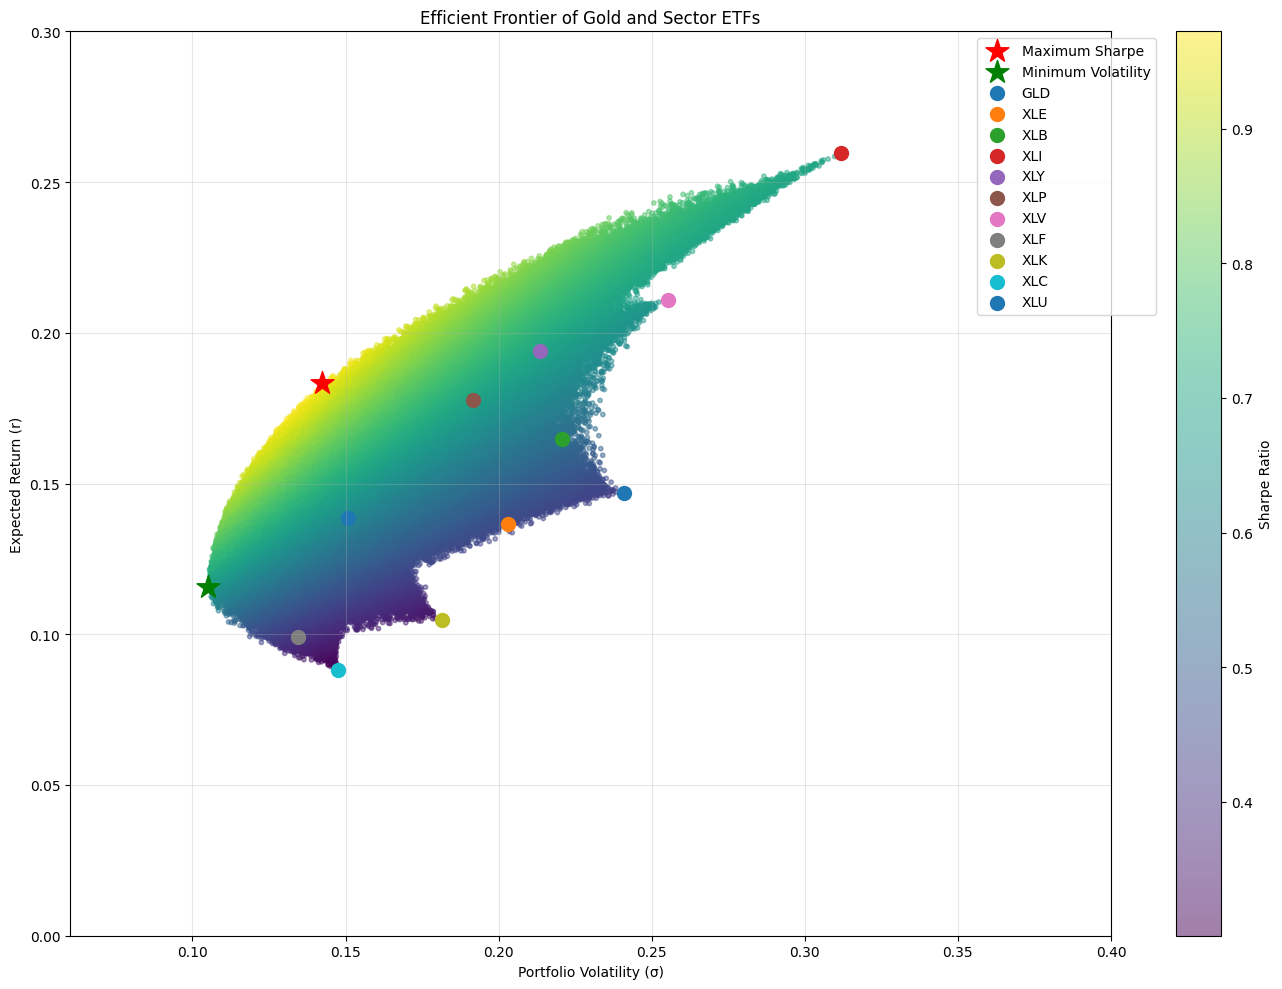

--------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

GLD: 47.94%
XLE: 0.55%
XLB: 0.14%
XLI: 22.46%
XLY: 13.53%
XLP: 0.29%
XLV: 14.03%
XLF: 0.41%
XLK: 0.61%
XLC: 0.03%
XLU: 0.00%
Expected Return: 18.32%
Expected Volatility: 14.22%
Sharpe Ratio: 0.97

--------------------------------------------------
Minimum Volatility Portfolio Allocation

GLD: 40.57%
XLE: 0.20%
XLB: 0.31%
XLI: 0.51%
XLY: 0.66%
XLP: 0.51%
XLV: 0.02%
XLF: 35.69%
XLK: 0.99%
XLC: 19.91%
XLU: 0.62%
Expected Return: 11.55%
Expected Volatility: 10.51%
Sharpe Ratio: 0.67


In [32]:
# Run the optimisation
optimiser = MultiAssetOptimisation(mean_returns, cov_matrix, tickers, volatilities)
optimiser.plot_efficient_frontier()

### Simplified Optimisation Code [using SciPy Minimize]

In [29]:
from scipy.optimize import minimize

def portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate=0.045):
    returns = np.dot(weights, mean_returns)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (returns - risk_free_rate) / std
    return returns, std, sharpe

# Optimise for Max. Sharpe
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate=0.045):
    returns, std, sharpe = portfolio_performance(weights, mean_returns, cov_matrix, risk_free_rate)
    return -sharpe  # negative because we want to maximise Sharpe [using a minimisation]

def max_sharpe_portfolio(mean_returns, cov_matrix, risk_free_rate=0.045):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # weights must sum to 1
    bounds = tuple((0, 1) for asset in range(num_assets))  # no short selling

    result = minimize(
        neg_sharpe_ratio,
        num_assets * [1. / num_assets],  # initial guess (evenly distributed)
        args=args,
        method='SLSQP', #SLSQP = Sequential Least SQuares Programming [not necessary to remember, it is just a method of optimisation]
        bounds=bounds,
        constraints=constraints
    )
    
    return result


# Optimise for Min. Volatility
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def min_volatility_portfolio(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))

    result = minimize(
        portfolio_volatility,
        num_assets * [1. / num_assets],
        args=(mean_returns, cov_matrix),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    
    return result

In [30]:
# Solve for Max. Sharpe Portfolio
sharpe_result = max_sharpe_portfolio(mean_returns, cov_matrix)
optimal_weights = sharpe_result.x

# Solve for Min. Volatility Portfolio
min_vol_result = min_volatility_portfolio(mean_returns, cov_matrix)
min_vol_weights = min_vol_result.x

# Print Allocations
print("Maximum Sharpe Ratio Portfolio Allocation:")
for ticker, weight in zip(returns.columns, optimal_weights):
    print(f"{ticker}: {weight:.2%}")

print("\nMinimum Volatility Portfolio Allocation:")
for ticker, weight in zip(returns.columns, min_vol_weights):
    print(f"{ticker}: {weight:.2%}")

# Portfolio Performance
opt_ret, opt_vol, opt_sharpe = portfolio_performance(optimal_weights, mean_returns, cov_matrix)
print(f"\nOptimal Expected Annual Return: {opt_ret:.2%}")
print(f"Optimal Annual Volatility: {opt_vol:.2%}")
print(f"Optimal Sharpe Ratio: {opt_sharpe:.2f}")


Maximum Sharpe Ratio Portfolio Allocation:
GLD: 49.07%
XLB: 0.00%
XLC: 0.00%
XLE: 15.19%
XLF: 20.10%
XLI: 0.00%
XLK: 15.64%
XLP: 0.00%
XLU: 0.00%
XLV: 0.00%
XLY: 0.00%

Minimum Volatility Portfolio Allocation:
GLD: 40.83%
XLB: 0.00%
XLC: 0.00%
XLE: 0.00%
XLF: 2.65%
XLI: 0.00%
XLK: 0.00%
XLP: 36.60%
XLU: 0.00%
XLV: 19.92%
XLY: 0.00%

Optimal Expected Annual Return: 17.94%
Optimal Annual Volatility: 13.67%
Optimal Sharpe Ratio: 0.98
